<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/03b_international_robustness_with_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install traffic

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
from functools import partialmethod
from google.colab import drive
import os
import glob
from traffic.data import airports
import altair as alt



define lists of airports with more than 50k passengers


In [3]:

# Deutschland
icaolistD=["EDDB", "EDVE", "EDDW", "EDLW", "EDDC", "EDDL", "EDDE", "EDDF", "EDFH", "EDNY", "EDDH", "EDDV", "EDSB", "EDVK", "EDDK", "EDDP", "EDHL", "EDJA", "EDDM", "EDDG", "EDLV", "EDDN", "EDLP", "ETNL", "EDDR", "EDDS", "EDXW"]

# Italien
icaolistI=["LIRF", "LIMC", "LIME", "LIRN", "LIPZ", "LICC", "LIPE", "LIML", "LICJ", "LIBD", "LIRP", "LIEE", "LIMF", "LIRA", "LIPX", "LIEO", "LIBR", "LIRQ", "LIPH", "LICA", "LIEA", "LICT", "LIMJ", "LIPQ", "LIBP", "LIRZ", "LIPY", "LICD", "LICB", "LICR", "LIPR", "LIBC", "LIPK", "LIMP", "LIMZ", "LICG"]

# Spanien - die, die nicht mit LE anfangen, sind abseits des Festlands, vor allem Canaren
icaolistS=["LEZL", "LEZG", "LEXJ", "LEVX", "LEVT", "LEVD", "LEVC", "LEST", "LESO", "LERS", "LEPP", "LEPA", "LEMI", "LEMH", "LEMG", "LEMD", "LELN", "LEJR", "LEIB", "LEGR", "LEGE", "LECO", "LEBZ", "LEBL", "LEBB", "LEAS", "LEAM", "LEAL", "GEML", "GCXO", "GCTS", "GCRR", "GCLP", "GCLA", "GCHI", "GCGM", "GCFV"]

# Frankreich - alles was nicht LF ist ist Übersee
icaolistF=["LFBD", "LFBE", "LFBH", "LFBL", "LFBO", "LFBP", "LFBT", "LFBZ", "LFGJ", "LFJL", "LFKB", "LFKC", "LFKF", "LFKJ", "LFLB", "LFLC", "LFLL", "LFLS", "LFMK", "LFML", "LFMN", "LFMP", "LFMT", "LFMU", "LFOB", "LFOT", "LFPB", "LFPG", "LFPO", "LFQQ", "LFRB", "LFRK", "LFRN", "LFRS", "LFSB", "LFST", "LFTH", "LFTW", "NTAA", "NTTB", "NTTG", "NTTH", "NTTR", "NWWL", "NWWM", "NWWW", "SOCA", "TFFF", "TFFG", "TFFJ", "TFRR", "FMCZ", "FMEE"]


where to save the data (and making sure that the directory exist)

In [4]:
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')
csv_files = glob.glob(os.path.join(folder_path, "combi*.csv"))
print(csv_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-02.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-03.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-04.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-05.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-06.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-07.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-08.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-09.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-10.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-11.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-12.csv', '/content/drive/My Drive/2024KomplexeNetze

In [5]:
# always useful
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")

let's define some functions we will use later. First:

Function to calculate international efficiency using the graph

In [6]:
def analyze_graph_IE(graph):
    total_reciprocal_shortest_paths = {}

    for icao in icaolist:
        if icao in graph: # Check if icao is in the graph
            total_reciprocal_shortest_path_for_icao = 0
            shortest_paths = nx.single_source_shortest_path_length(graph, source=icao)
            for arrival_airport in international_list:
                if arrival_airport in shortest_paths:
                    total_reciprocal_shortest_path_for_icao += 1/shortest_paths[arrival_airport]
                    total_reciprocal_shortest_paths[icao] = total_reciprocal_shortest_path_for_icao

    sum_of_reciprocals = sum(total_reciprocal_shortest_paths.values())
    IE = sum_of_reciprocals * 1/(len(international_list) * len(icaolist))
    #print(f"The international effiency of the given graph is: {IE}")

    return IE


Function to processes the input graph by creating subgraphs, reducing edge weights, and removing edges until no more destination nodes remain in the inputgraph that are not part of icaolist.
  

In [7]:
def process_graph(inputgraph, icaolist):
  subgraph_list = []

  while True:
      # Check if there are any destination nodes left that are not in icaolist
      destination_nodes_outside_icaolist = False
      for u, v, data in inputgraph.edges(data=True):
        if v not in icaolist:
            destination_nodes_outside_icaolist = True
            break

      if not destination_nodes_outside_icaolist or inputgraph.number_of_edges() == 0:
        break

      subgraph = nx.DiGraph()
      for u, v, data in inputgraph.edges(data=True):
          subgraph.add_edge(u, v, weight=1)

      subgraph_list.append(subgraph)

      edges_to_remove = []
      for u, v, data in inputgraph.edges(data=True):
          new_weight = data.get('weight', 1) - 1
          if new_weight <= 0:
              edges_to_remove.append((u, v))
          else:
              inputgraph[u][v]['weight'] = new_weight

      inputgraph.remove_edges_from(edges_to_remove)

  #print("Subgraph history length:", len(subgraph_list))
  return subgraph_list


And finally:
Function for the Weighted International Efficiency

*To clarify: what is the "number of connections between i and j" - per day, month, year, average?

Using per month I get WIE=3, using the average per week I get WIE=1.14 for 2024-01-01_2024-04-01.csv

In the Zhou 2021 paper they have 1.5 for Germany, but don't specify which "number of connections" they use.
... or maybe it doesn't matter, as long as we keep the same timeframe as base for comparisons. *


In [8]:
def analyze_graph_WIE(graph):
    decomposed_subgraphs = process_graph(graph, icaolist)

    total_ie = 0
    for subnet in decomposed_subgraphs:
      ie = analyze_graph_IE(subnet)
      total_ie += ie
    return total_ie


Another function that is needied as step 1 for international robustness:
remove the airport with the highest number of international connections


In [9]:
def remove_highest_degree_node(graph, icaolist):
    # Create a subgraph containing only nodes from the icaolist
    subgraph = graph.subgraph(icaolist)

    if not subgraph.nodes():
      return graph

    # Find the node with the highest degree in the subgraph
    highest_degree_node = max(subgraph.degree, key=lambda x: x[1])[0]

    # Create a copy of the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Remove the node and its connected edges from the modified graph
    modified_graph.remove_node(highest_degree_node)

    return modified_graph


--------------------------------------------

## Main Pairt

--------------------------------------------

now loop over the csv files, processing them one by one:
 - create directed graph
 - call my functions to determine WIE for each of them


In [25]:
icaolist = icaolistD


# Initialize lists to store WIE and IR values for each year
wie_2019 = []
wie_2018 = []
wie_2023 = []
wie_2024 = []
ir_2019 = []
ir_2018 = []
ir_2023 = []
ir_2024 = []
months = []

for csv_file in csv_files:

  flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])
  print(csv_file)


  #flightdata.head()
  #flightdata.describe()
  #nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
  #print(nan_percentage)
  flightdata.dropna(inplace=True)
  flightdata.describe()

  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "departure_city"})
  flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
  flightdata = flightdata.rename(columns={"municipality": "arrival_city"})

  # add a column to flightdata dataframe with contains week-and-year
  flightdata['week_and_year'] = flightdata['day'].dt.strftime('%Y-%U')
  #flightdata.tail()

  # add a column to flightdata dataframe with contains month-and-year
  flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')
  #flightdata.tail()


  # Create a directed graph
  trafficgraph = nx.DiGraph()

  # query dataframe for everything starting/ending at one of the selected airports
  flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]

  weightedgraph = nx.DiGraph()

  # Part 1: Add nodes from the flights data
  for index, row in flightdata.iterrows():
      origin = row['departure']
      destination = row['arrival']

      # Add the origin and destination as nodes if they don't exist
      if origin not in weightedgraph:
          weightedgraph.add_node(origin)
      if destination not in weightedgraph:
          weightedgraph.add_node(destination)


  print("Number of nodes (airports):", weightedgraph.number_of_nodes())

  # Part 2: Add weighted edges from the flights data

  # Group flights by origin, destination, and day to count weekly connections
  weekly_connections = flightdata.groupby(['departure', 'arrival', 'week_and_year']).size().reset_index(name='connections')
  print(weekly_connections.tail())
  average_connections = weekly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
  print(average_connections.tail())

  # Group flights by origin, destination, and day to count monthly connections
  #monthly_connections = flightdata.groupby(['departure', 'arrival', 'month_and_year']).size().reset_index(name='connections')
  #print(monthly_connections.tail())

  # Calculate the average connections for each departure-arrival combination
  #average_connections = monthly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
  #print(average_connections.tail())

  # Add weighted edges based on average connections
  for index, row in average_connections.iterrows():
      origin = row['departure']
      destination = row['arrival']
      weight = row['connections']

      # Add the edge with the calculated weight
      if origin in weightedgraph and destination in weightedgraph:
          weightedgraph.add_edge(origin, destination, weight=weight)


  print("Number of edges (flights):", weightedgraph.number_of_edges())

  international_list = flightdata[~flightdata['arrival'].isin(icaolist)]['arrival'].unique()

  print (f'Found {len(international_list)} international airports to check against')

  domestic_departure_graph = nx.DiGraph()
  for u, v, data in weightedgraph.edges(data=True):
    if u in icaolist:
      domestic_departure_graph.add_edge(u, v, **data) # Keep the edge data/weight
  print("Number of edges (flights):", domestic_departure_graph.number_of_edges())

  # Extract year and month from filename
  filename = os.path.basename(csv_file)
  year = int(filename[6:10])  # Extract four digits after "combi_"
  month = int(filename[-6:-4])  # Extract two digits before ".csv"

  # Let's see what the WIE is
  # While doing that, calculate the ratio of post- and pre- WIEs.
  modified_graph = domestic_departure_graph.copy()
  sum_ratio = 0
  WIE_pre = analyze_graph_WIE(modified_graph.copy())
  if year == 2019:
    wie_2019.append(WIE_pre)
    months.append(month)
  elif year == 2018:
    wie_2018.append(WIE_pre)
  elif year == 2023:
    wie_2023.append(WIE_pre)
  elif year == 2024:
    wie_2024.append(WIE_pre)

  while True and WIE_pre > 0:
      nodes_in_icaolist = [node for node in modified_graph.nodes if node in icaolist]
      if not nodes_in_icaolist:
          break
      modified_graph = remove_highest_degree_node(modified_graph, icaolist)
      WIE_post=analyze_graph_WIE(modified_graph.copy())
      ratio = WIE_post/WIE_pre
      if WIE_post == 0:
          print("WIE_post has become zero.")
      WIE_pre = WIE_post
      sum_ratio += ratio

  ir = sum_ratio / len(icaolist)
  if year == 2019:
    ir_2019.append(ir)
  elif year == 2018:
    ir_2018.append(ir)
  elif year == 2023:
    ir_2023.append(ir)
  elif year == 2024:
    ir_2024.append(ir)
    print(f"International robustness for {csv_file}: {ir}")

/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-01.csv
Number of nodes (airports): 28
   departure arrival week_and_year  connections
20      EDDW    LFBO       2018-02            1
21      ESSA    EDDP       2018-00            1
22      KIAD    EDDF       2018-03            1
23      LIPZ    EDDK       2018-03            1
24      LIPZ    EDDP       2018-01            1
   departure arrival  connections
20      EDDW    LFBO          1.0
21      ESSA    EDDP          1.0
22      KIAD    EDDF          1.0
23      LIPZ    EDDK          1.0
24      LIPZ    EDDP          1.0
Number of edges (flights): 25
Found 18 international airports to check against
Number of edges (flights): 21
WIE_post has become zero.
/content/drive/My Drive/2024KomplexeNetze/Daten/combi_2018-02.csv
Number of nodes (airports): 26
   departure arrival week_and_year  connections
14      LIMC    EDDH       2018-08            1
15      LOWW    EDDK       2018-05            1
16      LSGG    EDDB       2018-07 

Now make a plot of the reults

In [ ]:
# prompt: make a copy of months array, without the last entry



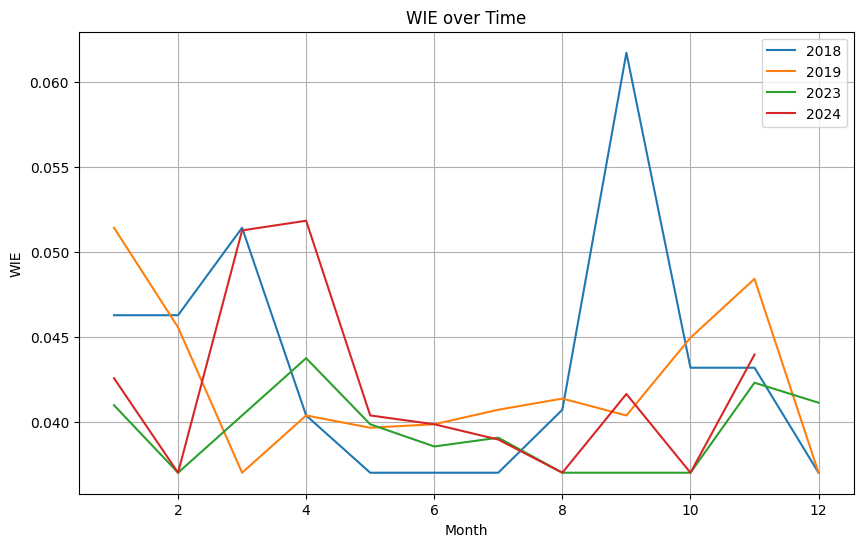

In [28]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(months, wie_2018, label='2018')
plt.plot(months, wie_2019, label='2019')
plt.plot(months, wie_2023, label='2023')
# ensure all lists have the same length
plt.plot(months[:-1], wie_2024, label='2024')

plt.xlabel('Month')
plt.ylabel('WIE')
plt.title('WIE over Time')
plt.legend()
plt.grid(True)
plt.show()

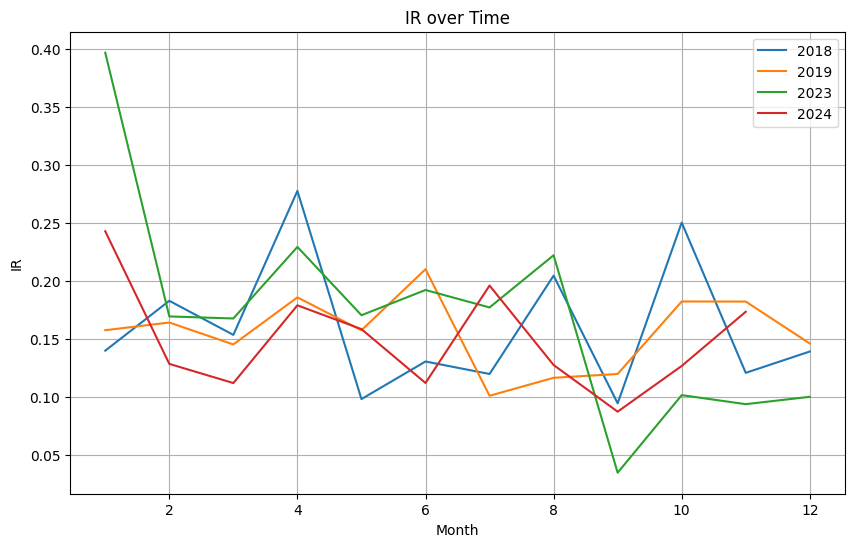

In [29]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(months, ir_2018, label='2018')
plt.plot(months, ir_2019, label='2019')
plt.plot(months, ir_2023, label='2023')
plt.plot(months[:-1], ir_2024, label='2024')

plt.xlabel('Month')
plt.ylabel('IR')
plt.title('IR over Time')
plt.legend()
plt.grid(True)
plt.show()